# Goal

1. Our goal is to build a basic soybean yield model to predict the final yearly yield of that crop.  We will use features such as temperature (avg) and precipitation, US state, NDVI (measure of quality), podcount and test a shift operator to test the hypothesis that technolical change in the last few years has significantly, on linearly, increased yields

1. Yearly yields:
    
    <font size="3"> $$ Yields_{y} \sim PodCount_{m} + State_{y} + Temp_{m} + Precip_{m} + Quality_{m} + Droughts_{m} + Shift + error_{y} $$ </font>
    

# Long term Goals:
1. Automate process of modeling yield forecasts.
2. Incorporate global data.
3. Provide a range of forecasts.

# Immediate Goals:
1. Use US data to forecast soybean yields.
2. Automate downloading of data and model scoring.
3. Provide figures.
4. Test and compare several forecasting methods.

# <u>Features</u>

## Yields

### Hypothsis: Historical yields are a good indicator of future yields.

1. Plots clearly show a significant trend.

## Pod Count

### Hypothesis: A good pod count indicates a good final yield.

1. We aren't interested in the final pod count, rather the intermediate counts as a way to predict the final yields (which is highly related to the count).
2. So we need the pod counts for several intermediate months.
3. Available on a monthly basis, starting late in the year (Sep?).



## Weather Features

1. Bad weather in particular months will damage the soybean crops.  
2. Look at min, max and precipitation.
3. Try to identify patterns in extreme events.

## Quality of Crop
1. This is another feature examining the quality of a crop at a particular moment.
2. Available on a semi-weekly basis.  



# <u>Models</u>

item:  0
i:  IOWA
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     167.1
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           2.22e-50
Time:                        12:30:15   Log-Likelihood:                -213.66
No. Observations:                  92   AIC:                             451.3
Df Residuals:                      80   BIC:                             481.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

,State,Year,Real*,trend_pred,trend_sqr_pred,arima_pred,maxTemp_pred,maxT_Precip_pred,drought_pred,drought_pred_zndx1,quality_pred,mixed_pred,trend_augPrecip_pred
0,IOWA,2016,60.0,51.761228,52.931916,53.194382,52.790528,54.840091,53.460414,55.089674,55.876519,54.675767,54.606879
1,IOWA,2017,57.0,52.198122,53.444338,54.177802,54.963467,54.473555,54.498755,54.451072,51.441458,54.949402,54.089709
2,IOWA,2018,56.0,52.635016,53.958368,54.929376,53.692649,55.585703,56.382073,56.163742,54.796135,56.288711,55.580700
3,IOWA,2019,55.0,53.071910,54.474004,55.628360,55.430471,55.413277,55.072859,55.720675,51.667972,55.848987,54.793839
4,IOWA,2020,58.0,53.508804,54.991247,56.380423,53.941179,51.626294,53.209601,51.336555,47.623010,51.096631,51.149733


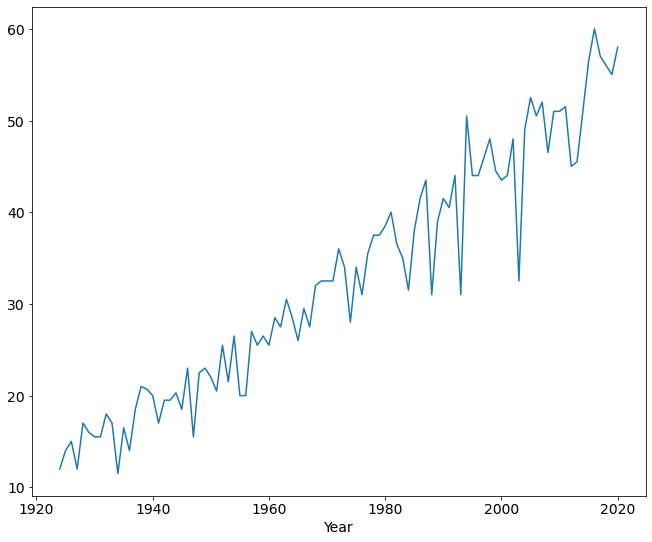

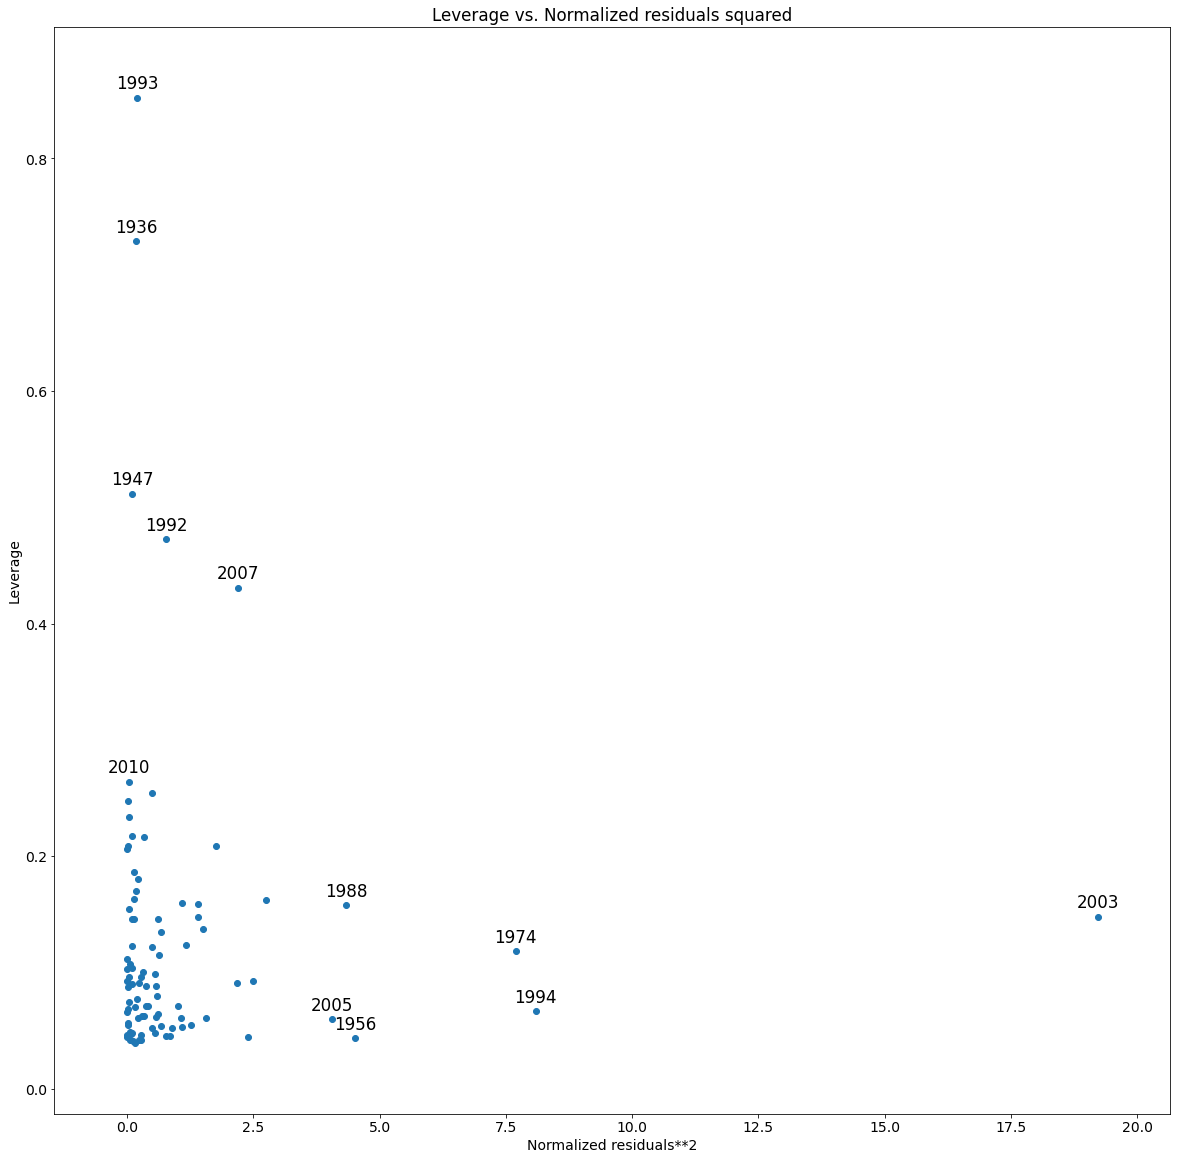

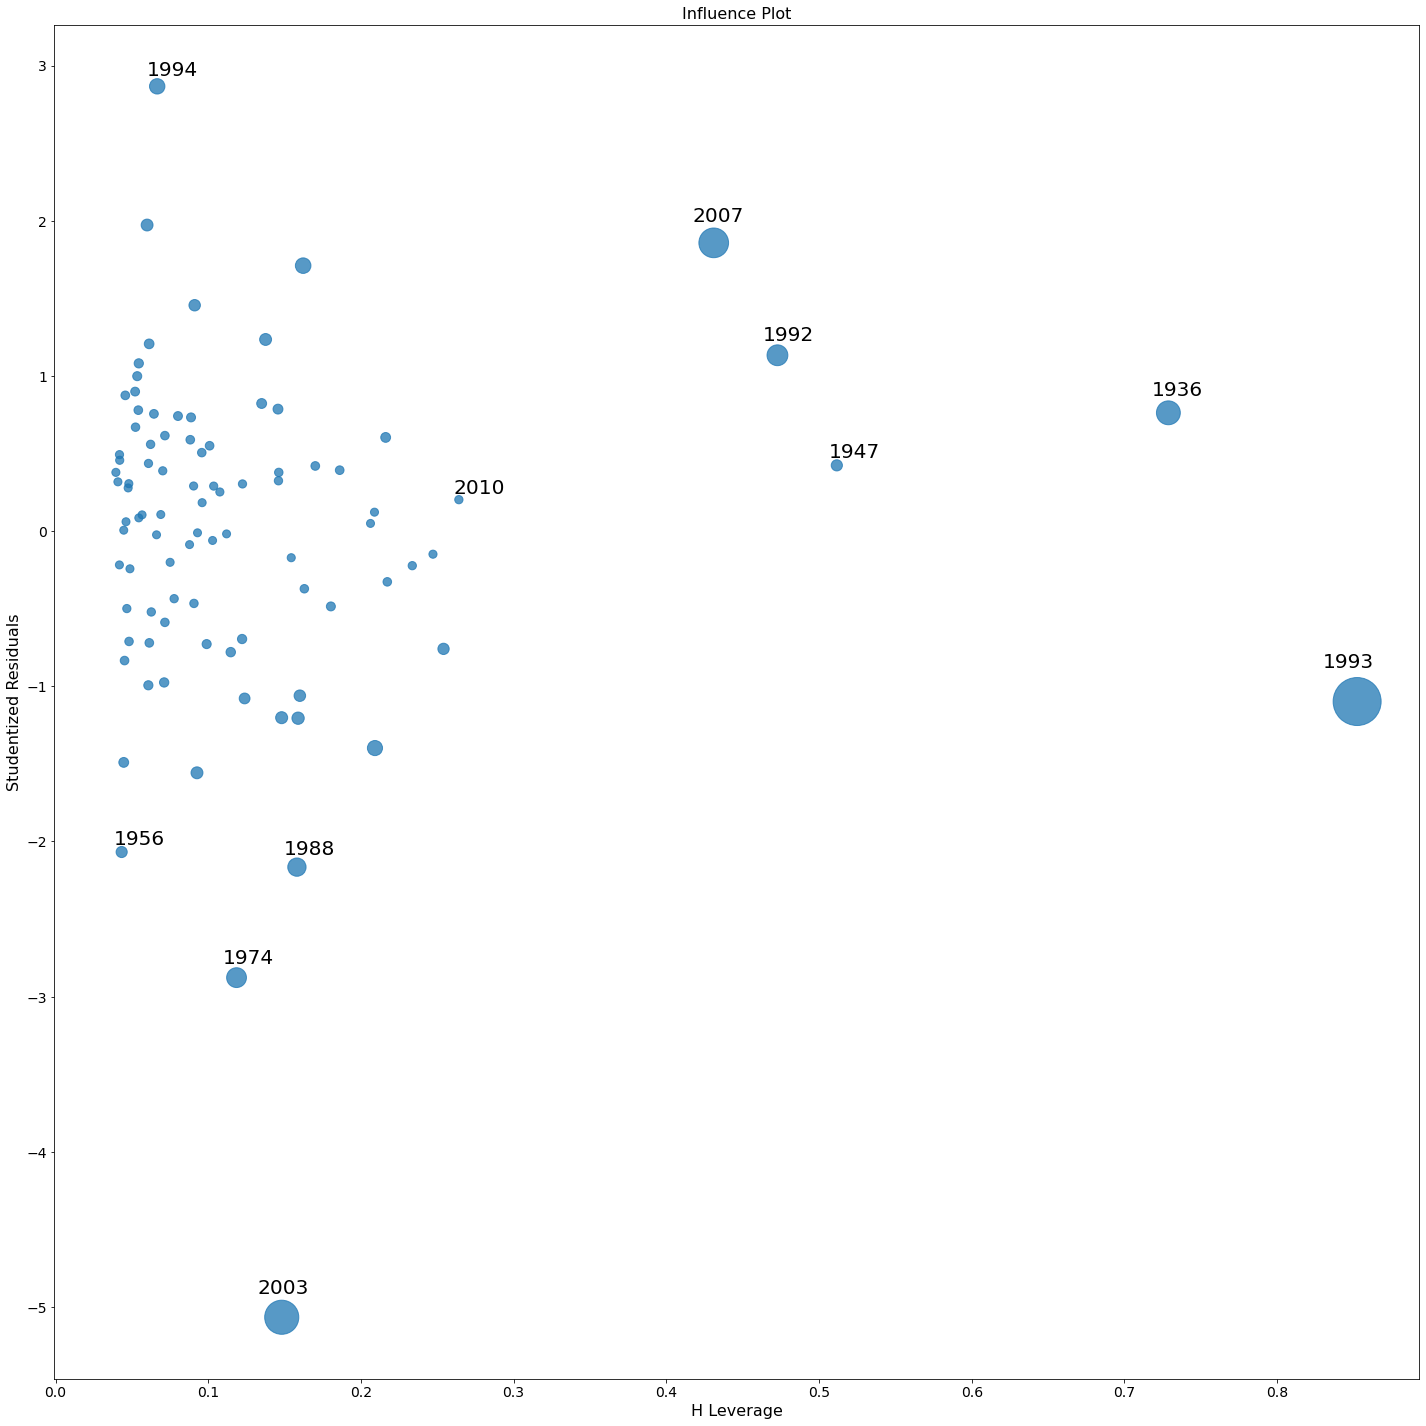

In [41]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
#import pandoc

testYear = 2016
startYear = 1800

statesofInterest = ['IOWA', 'INDIANA', 'ILLINOIS', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'SOUTH DAKOTA', 'OHIO']
statesofInterest = ['IOWA']
myGuesses = []
for item, i in enumerate(statesofInterest):
    
    print("item: ", item)
    print("i: ", i)

    ##################################################
    # yield 
    yld1 = pd.read_csv("data_model_ready/model_allStates_yields.csv")
    yld1 = yld1[yld1["Year"] > startYear]
    yld1.set_index('Year', inplace=True, drop=False)
    iowa1 = yld1[yld1["State"] == i]
    real1 = iowa1.tail(5)["Yield"]
    iowa1["Yield"].plot(figsize=(11, 9))
    
    test1 = iowa1[iowa1["Year"] < testYear]
    real_pred = iowa1[iowa1["Year"] >= testYear].Yield

    ##################################################
    # trend only 
    results = smf.ols('Yield ~ Year', data=test1).fit()
    ypred = results.predict(test1["Year"])
   
    Xnew = pd.DataFrame({"Year": list(range(testYear, 2021))})
    Xnewl = list(range(testYear, 2021))
    Xnewc = sm.add_constant(Xnew)
    ynewpred =  results.predict(Xnewc) # predict out of sample
    trend_pred =  results.predict(Xnewc) # predict out of sample

    ##################################################
    # trend plus trend squared
    results2 = smf.ols('Yield ~ Year + I(Year**2)', data=test1).fit()
    
    Xnew = pd.DataFrame({"Year": list(range(testYear, 2021))})
    Xnewc = sm.add_constant(Xnew)
    ynewpred2 =  results2.predict(Xnewc) # predict out of sample
    trend_sqr_pred = results2.predict(Xnewc) # predict out of sample

    ##################################################    
    # ARIMA
    series = test1["Yield"] 
    mod = sm.tsa.SARIMAX(series, order=(2, 1, 2), trend='t')
    # Estimate the parameters
    res = mod.fit()

    arima_pred = res.forecast(2021 - testYear)

    ##################################################
    ## max temp  model
    tmax1 = pd.read_csv("data_model_ready/model_allStates_maxTemp1.csv")
    tmax1.set_index('Year', inplace=True, drop=False)
    tmax1 = tmax1[tmax1["State"] == i]
    tmax1 = tmax1[["Maxtemp_Aug", "Maxtemp_Jul", "Year"]]
    iowa2 = iowa1[["Yield"]]
    iowa3 = iowa2.join(tmax1)

    test1 = iowa3[iowa3["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Jul + Maxtemp_Aug', data=test1).fit()
   
    train1 = iowa3[iowa3["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    maxTemp_pred =  results.predict(train1) # predict out of sample

    tmin1 = pd.read_csv("data_model_ready/model_allStates_minTemp1.csv")
    tmin1.set_index('Year', inplace=True, drop=False)
    tmin1 = tmin1[tmin1["State"] == i]
    tmin1 = tmin1[["Mintemp_Jul", "Mintemp_Aug", "Year"]]
    tmin1.drop(["Year"], axis=1, inplace=True)
    iowa4 = iowa3.join(tmin1)
    iowa4["AvgTemp_Aug"] = iowa4[['Maxtemp_Aug', 'Mintemp_Aug']].mean(axis=1)
    #iowa4.loc[2020, "AvgTemp_Aug"] = stateAugTemp[item]

    ##################################################
    ## max temp and precip model
    precip1 = pd.read_csv("data_model_ready/model_allStates_precip.csv")
    precip1.set_index('Year', inplace=True, drop=True)
    precip1 = precip1[precip1["State"] == i]
    numRows = precip1.shape[0]
    #precip1.loc[2020,'Precip_Aug'] = statePrecip[item]
    precip1["Year"] = precip1.index
    
    precip1 = precip1[["Precip_Aug", "Precip_Jul", "Precip_Sep"]]
    precip1.replace(-9.99, np.nan, inplace=True)
    iowa5 = iowa4.join(precip1)
    
    test1 = iowa5[iowa5["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Jul + Maxtemp_Aug + Precip_Jul + I(Precip_Jul**2) + Precip_Aug + I(Precip_Aug**2) + I(Maxtemp_Jul*Maxtemp_Aug)', data=test1).fit()
    
    train1 = iowa5[iowa5["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    ###
    maxT_Precip_pred =  results.predict(train1) # predict out of sample
    
    
    ##################################################
    ## drought data
    pmdi1 = pd.read_csv("data_model_ready/model_allStates_pmdi1.csv")
    pmdi1.set_index('Year', inplace=True, drop=True)
    pmdi1 = pmdi1[pmdi1["State"] == i]
    numRows = pmdi1.shape[0]
    #precip1.loc[2020,'Precip_Aug'] = statePrecip[item]
    pmdi1["Year"] = pmdi1.index
    
    pmdi1 = pmdi1[["Pmdi1_Jun", "Pmdi1_Aug", "Pmdi1_Jul", "Pmdi1_Sep"]]
    pmdi1.replace(-99.99, np.nan, inplace=True)
    iowa6 = iowa5.join(pmdi1)
    
    test1 = iowa6[iowa6["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Pmdi1_Jul + I(Pmdi1_Jul**2) + Pmdi1_Aug + I(Pmdi1_Aug**2) + Maxtemp_Jul + I(Maxtemp_Jul**2) + Maxtemp_Aug + I(Maxtemp_Aug**2) + I(Maxtemp_Jul*Maxtemp_Aug)', data=test1).fit()
    
    train1 = iowa6[iowa6["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    ###
    drought_pred =  results.predict(train1) # predict out of sample
    
    
    ##################################################
    ## drought data 2
    zndx1 = pd.read_csv("data_model_ready/model_allStates_zndx1.csv")
    zndx1.set_index('Year', inplace=True, drop=True)
    zndx1 = zndx1[zndx1["State"] == i]
    numRows = zndx1.shape[0]
    #precip1.loc[2020,'Precip_Aug'] = statePrecip[item]
    zndx1["Year"] = zndx1.index
    
    zndx1 = zndx1[["Zndx1_Jun", "Zndx1_Aug", "Zndx1_Jul", "Zndx1_Sep"]]
    zndx1.replace(-99.99, np.nan, inplace=True)
    iowa7 = iowa6.join(zndx1)
    
    test1 = iowa7[iowa7["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Zndx1_Jul + I(Zndx1_Jul**2) + Zndx1_Aug + I(Zndx1_Aug**2) + Maxtemp_Jul + I(Maxtemp_Jul**2) + Maxtemp_Aug + I(Maxtemp_Aug**2) + I(Maxtemp_Jul*Maxtemp_Aug)', data=test1).fit()
    
    print(results.summary())
        
    train1 = iowa7[iowa7["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    ###
    drought_pred_zndx1 =  results.predict(train1) # predict out of sample

    
    ##################################################
    ## podcount model
    podcount = pd.read_csv("data_model_ready/model_allStates_podcount.csv")
    podcount.set_index('Year', inplace=True, drop=False)
    podcount = podcount[podcount["State"] == i]

    podcount = podcount[["Sep_pod_forecast", "Nov_pod_forecast"]]
    iowa8 = iowa7.join(podcount)

    
    test1 = iowa8[iowa8["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug + Precip_Aug + I(Precip_Aug**2) + Nov_pod_forecast', data=test1).fit()

    train1 = iowa8[iowa8["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    pod_pred =  results.predict(train1) # predict out of sample

    
    ##################################################
    ## Qualtiy model
    quality = pd.read_csv("data_model_ready/model_allStates_quality.csv")
    quality.set_index('Year', inplace=True, drop=False)
    quality = quality[quality["State"] == i]
  
    quality = quality[['WEEK #35PCT EXCELLENT']]
    quality.rename(columns={'WEEK #35PCT EXCELLENT': 'WEEK_35PCT_EXCELLENT'}, inplace=True)
    iowa9 = iowa8.join(quality)
    #####
    iowa9.to_csv("tmp_data/modelData_" + i + ".csv")
    #####
    
    test1 = iowa9[iowa9["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug + Mintemp_Aug + Precip_Aug + I(Precip_Aug**2) + WEEK_35PCT_EXCELLENT', data=test1).fit()
    
    train1 = iowa9[iowa9["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    quality_pred =  results.predict(train1) # predict out of sample

    ##################################################
    ## Mixed model
    test1 = iowa9[iowa9["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2)  + I(Year**3) + Zndx1_Jul + I(Zndx1_Jul**2) + Zndx1_Aug + I(Zndx1_Aug**2) + Maxtemp_Jul + I(Maxtemp_Jul**2) + Maxtemp_Aug + I(Maxtemp_Aug**2) + I(Zndx1_Jul*Zndx1_Aug)', data=test1).fit()
    if i == "IOWA":
        print(results.summary())
     
    plt.rc("figure", figsize=(20,20))
    plt.rc("font", size=14)
    
    
    from statsmodels.graphics.regressionplots import plot_leverage_resid2
    fig, ax = plt.subplots()
    fig = plot_leverage_resid2(results, ax = ax)
    
    
    fig = sm.graphics.influence_plot(results, criterion="cooks")
    fig.tight_layout(pad=1.0)
    
    
    train1 = iowa9[iowa9["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    mixed_pred =  results.predict(train1) # predict out of sample
    if i == "IOWA":
        predictions = results.get_prediction(train1)
        print(predictions.summary_frame(alpha=0.05))
    
    ##################################################
     ## Just August precip model
    test1 = iowa9[iowa9["Year"] < testYear]
    results = smf.ols('Yield ~ Year + I(Year**2) + Precip_Aug + I(Precip_Aug**2)', data=test1).fit()
    #print(results.summary())
    
    train1 = iowa9[iowa9["Year"] >= testYear]
    ynewpred =  results.predict(train1) # predict out of sample
    trend_augPrecip_pred =  results.predict(train1) # predict out of sample
    
    #######################
    output  = pd.DataFrame({"State": i,
                            "Year": range(testYear, 2021),
                            "Real*": real_pred.tolist(),
                            "trend_pred": trend_pred, 
                            "trend_sqr_pred": trend_sqr_pred,    
                            "arima_pred": arima_pred.tolist(),
                            "maxTemp_pred": maxTemp_pred.tolist(),
                            "maxT_Precip_pred": maxT_Precip_pred.tolist(),
                            "drought_pred": drought_pred.tolist(),
                            "drought_pred_zndx1": drought_pred_zndx1.tolist(),
                            "pod_pred": pod_pred.tolist(),
                            "quality_pred": quality_pred.tolist(),
                            "mixed_pred": mixed_pred.tolist(),
                            "trend_augPrecip_pred": trend_augPrecip_pred.tolist()
                            })
    myGuesses.append(output)

guesses = pd.concat(myGuesses)
guess1 = guesses.loc[:, guesses.notna().all()]
guess1.to_csv("guesses.csv", index = None)
guess1